In [1]:

import os, random
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms, models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, brier_score_loss, precision_recall_curve
import joblib
from PIL import Image
print(torch.cuda.is_available())
print(torch.cuda.device_count())


True
1


**Este script entrena una red neuronal MobilenetV2 para detectar si una imagen tiene cruz o no**

INPUT: imagenes de cruces e imagenes sin cruces (ya seleccionadas). Carpetas: _CROSSED_ y _UNCROSSED_

OUTPUT: modelo MobilenetV2 entrenado

**VERSION 2**

Calibracion del score. "0.9 significa que 9 de cada 10 estan bien"

Entreno la red...

In [ ]:
# --- PARAMETROS ---
BATCH_SIZE = 32
IMG_SIZE = 64  # or 128, 96, etc
EPOCHS = 30
DATA_DIR = "entrenamiento"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# --- DATA TRANSFORMS ---
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- DATASETS & LOADERS ---
train_dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=train_transform
)
val_dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=val_transform
)

# Separo train/val (80/20)
n_total = len(train_dataset)
n_val = int(0.2 * n_total)
n_train = n_total - n_val
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_val])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- MODEL ---
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, 1)  # Binary classification
model = model.to(DEVICE)

# --- LOSS & OPTIMIZER ---
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# --- TRAIN LOOP ---
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE).float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += imgs.size(0)
    return running_loss / total, correct / total

def eval_model(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE).float().unsqueeze(1)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).int()
            correct += (preds == labels.int()).sum().item()
            total += imgs.size(0)
    return running_loss / total, correct / total

# --- TRAINING ---
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = eval_model(model, val_loader, criterion)
    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.3f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.3f}")

# --- SAVE MODEL ---
torch.save(model.state_dict(), "cell_cross_classifier_con_ABCD.pt")
print("Model saved as cell_cross_classifier.pt")

# --- OPTIONAL: Funcion de inferencia ---
def predict_image(path, model, device=DEVICE):
    img = torchvision.io.read_image(path)
    img = transforms.functional.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.float() / 255.0
    img = img.unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        out = model(img)
        prob = torch.sigmoid(out).cpu().item()
    return "cross" if prob > 0.5 else "no_cross", prob

/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 | Train Loss: 0.0997 Acc: 0.962 | Val Loss: 0.0339 Acc: 0.986
Epoch 2/5 | Train Loss: 0.0480 Acc: 0.986 | Val Loss: 0.0120 Acc: 0.997
Epoch 3/5 | Train Loss: 0.0324 Acc: 0.988 | Val Loss: 0.0068 Acc: 0.998
Epoch 4/5 | Train Loss: 0.0272 Acc: 0.992 | Val Loss: 0.0220 Acc: 1.000
Epoch 5/5 | Train Loss: 0.0201 Acc: 0.994 | Val Loss: 0.0130 Acc: 0.998
Model saved as cell_cross_classifier_5epoch.pt


Observo que tan lejos esta el score que me da la red del nivel de confianza

In [34]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Reconstruir arquitectura igual a la de entrenamiento
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 1)

# Cargar pesos entrenados
state = torch.load("cell_cross_classifier.pt", map_location=DEVICE)
model.load_state_dict(state)

# Pasar a dispositivo y a modo evaluación
model = model.to(DEVICE).eval()

/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# --- PARAMS ---
BATCH_SIZE = 32
IMG_SIZE = 64
DATA_DIR_TRAIN = "entrenamiento"
DATA_DIR_VAL   = "validacion"

# --- TRANSFORMS  ---
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- DATASETS ---
train_dataset = datasets.ImageFolder(root=DATA_DIR_TRAIN, transform=train_transform)
val_full      = datasets.ImageFolder(root=DATA_DIR_VAL,   transform=val_transform)

# --- SPLIT ESTRATIFICADO 50/50 SOBRE validation ---
rng = np.random.default_rng(seed=42)  # reproducible

# ImageFolder guarda rutas+label en .samples (tuplas (path, label))
paths, labels = zip(*val_full.samples)
labels = np.array(labels)

calib_idx, holdout_idx = [], []
classes = np.unique(labels)
for c in classes:
    idx_c = np.where(labels == c)[0]
    rng.shuffle(idx_c)
    n_c = len(idx_c)
    n_calib_c = n_c // 2  # 50%
    calib_idx.extend(idx_c[:n_calib_c].tolist())
    holdout_idx.extend(idx_c[n_calib_c:].tolist())

# (opcional) mezclar el orden final, pero no cambia el contenido
rng.shuffle(calib_idx)
rng.shuffle(holdout_idx)

calib_dataset   = Subset(val_full, calib_idx)
holdout_dataset = Subset(val_full, holdout_idx)

# --- LOADERS ---
train_loader   = DataLoader(train_dataset,   batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
calib_loader   = DataLoader(calib_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
holdout_loader = DataLoader(holdout_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Calibración: {len(calib_dataset)} imágenes | Holdout: {len(holdout_dataset)} imágenes")
print("class_to_idx:", train_dataset.class_to_idx)

Calibración: 488 imágenes | Holdout: 489 imágenes
class_to_idx: {'0-CROSSED': 0, '0-UNCROSSED': 1}


== MÉTRICAS SIN CALIBRAR ==
AUC-ROC: 1.0000
AP (PR-AUC): 1.0000
Brier score: 0.0000
ECE: 0.0002

== Tabla de bins (confianza media vs. accuracy real) ==
[{'acc': 0.0,
  'bin_center': 0.03333333333333333,
  'bin_left': 0.0,
  'bin_right': 0.06666666666666667,
  'conf_mean': 0.0006140003679320216,
  'count': 118,
  'gap': -0.0006140003679320216},
 {'acc': 1.0,
  'bin_center': 0.9666666666666667,
  'bin_left': 0.9333333333333333,
  'bin_right': 1.0,
  'conf_mean': 0.9999037384986877,
  'count': 371,
  'gap': 9.626150131225586e-05}]


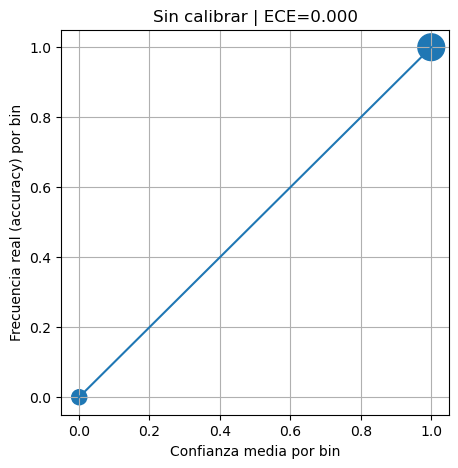

In [ ]:
# ============================================
# EVALUAR CALIBRACIÓN SIN CALIBRAR (RAW)
# - Colecta logits y labels en set de evaluación (holdout o validation)
# - Calcula probabilidades (sigmoide)
# - Mide Brier score y ECE
# - Arma tabla por bins (confianza vs. accuracy real)
# - Grafica Reliability Diagram
# ============================================

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE).eval()  # asegurarme de tener modelo cargado (state_dict) antes

# ------------------------------------------------
# Utilidad: recolectar LOGITS (sin sigmoide) y LABELS (0/1)
# ------------------------------------------------
@torch.no_grad()
def collect_logits_labels(model: nn.Module, loader: DataLoader, device: str = DEVICE):
    model.eval()
    all_logits, all_labels = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.float().to(device)  # 0/1
        logits = model(imgs).squeeze(1)     # [B]
        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())
    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    return logits, labels

# Usa en el loader de evaluación:
# - Hice split estratificado: uso 'holdout_loader'
# - No hice split: uso 'val_loader'
eval_loader = holdout_loader  # o val_loader

logits, labels = collect_logits_labels(model, eval_loader, DEVICE)

# ------------------------------------------------
# Probabilidades "raw" (sin calibrar)
# ------------------------------------------------
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

probs_raw = sigmoid(logits)

# ------------------------------------------------
# Métricas de calibración y discriminación
#    - Brier score: menor es mejor (calibración)
#    - ECE: menor es mejor (calibración)
#    - AUC/AP: discriminación (no miden calibración)
# ------------------------------------------------
def calibration_bins(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15):
    """
    Divide las predicciones en 'n_bins' por su probabilidad predicha (confianza).
    Devuelve stats por bin y ECE.
    """
    assert probs.shape[0] == labels.shape[0]
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(probs, bins) - 1  # bin para cada muestra
    ece = 0.0
    stats = []  # lista de dicts con info por bin

    N = len(labels)
    for b in range(n_bins):
        mask = (idx == b)
        count = int(mask.sum())
        if count == 0:
            continue
        conf_mean = probs[mask].mean()        # confianza media predicha
        acc = (labels[mask] == 1).mean()      # frecuencia real de positivos
        weight = count / N
        ece += abs(acc - conf_mean) * weight
        stats.append({
            "bin_left": float(bins[b]),
            "bin_right": float(bins[b+1]),
            "bin_center": float((bins[b] + bins[b+1]) / 2),
            "count": count,
            "conf_mean": float(conf_mean),
            "acc": float(acc),
            "gap": float(acc - conf_mean),  # positivo=subconfiado, negativo=sobreconfiado
        })
    return ece, stats

brier = brier_score_loss(labels, probs_raw)
ece, stats = calibration_bins(probs_raw, labels, n_bins=15)
auc = roc_auc_score(labels, probs_raw)
ap  = average_precision_score(labels, probs_raw)

print("== MÉTRICAS SIN CALIBRAR ==")
print(f"AUC-ROC: {auc:.4f}")
print(f"AP (PR-AUC): {ap:.4f}")
print(f"Brier score: {brier:.4f}")
print(f"ECE: {ece:.4f}")

# ------------------------------------------------
# Mostrar tabla por bins (confianza vs. accuracy real)
# ------------------------------------------------
from pprint import pprint
print("\n== Tabla de bins (confianza media vs. accuracy real) ==")
pprint(stats)  # cada fila tiene: rango del bin, count, conf_mean, acc, gap

# ------------------------------------------------
# Graficar Reliability Diagram (sin colores específicos)
#    - Línea diagonal: calibración perfecta
#    - Curva del modelo: cómo se comporta
# ------------------------------------------------
def plot_reliability(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15, title="Reliability Diagram"):
    ece, stats = calibration_bins(probs, labels, n_bins=n_bins)
    xs = [s["conf_mean"] for s in stats]  # x: confianza media
    ys = [s["acc"] for s in stats]        # y: accuracy real por bin
    sizes = [max(20, s["count"]) for s in stats]  # tamaño proporcional al # de puntos (opcional)

    plt.figure(figsize=(5,5))
    plt.plot([0,1], [0,1])  # diagonal: ideal
    plt.scatter(xs, ys, s=sizes)  # puntos por bin
    plt.xlabel("Confianza media por bin")
    plt.ylabel("Frecuencia real (accuracy) por bin")
    plt.title(f"{title} | ECE={ece:.3f}")
    plt.grid(True)
    plt.show()

plot_reliability(probs_raw, labels, n_bins=15, title="Sin calibrar")


Calibro la red (si hace falta)

In [ ]:
# --- PARAMS ---
BATCH_SIZE = 32
IMG_SIZE = 64
DATA_DIR_TRAIN = "entrenamiento"         # carpeta de entrenamiento
DATA_DIR_VAL   = "validacion"    # carpeta de validación (nunca vista)

# --- TRANSFORMS  ---
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- DATASETS ---
train_dataset = datasets.ImageFolder(root=DATA_DIR_TRAIN, transform=train_transform)
val_full      = datasets.ImageFolder(root=DATA_DIR_VAL,   transform=val_transform)

# --- SPLIT ESTRATIFICADO 50/50 SOBRE validation ---
rng = np.random.default_rng(seed=42)  # reproducible

# ImageFolder guarda rutas+label en .samples (tuplas (path, label))
paths, labels = zip(*val_full.samples)
labels = np.array(labels)

calib_idx, holdout_idx = [], []
classes = np.unique(labels)
for c in classes:
    idx_c = np.where(labels == c)[0]
    rng.shuffle(idx_c)
    n_c = len(idx_c)
    n_calib_c = n_c // 2  # 50%
    calib_idx.extend(idx_c[:n_calib_c].tolist())
    holdout_idx.extend(idx_c[n_calib_c:].tolist())

# (opcional) mezclar el orden final, pero no cambia el contenido
rng.shuffle(calib_idx)
rng.shuffle(holdout_idx)

calib_dataset   = Subset(val_full, calib_idx)
holdout_dataset = Subset(val_full, holdout_idx)

# --- LOADERS ---
train_loader   = DataLoader(train_dataset,   batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
calib_loader   = DataLoader(calib_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
holdout_loader = DataLoader(holdout_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Calibración: {len(calib_dataset)} imágenes | Holdout: {len(holdout_dataset)} imágenes")
print("class_to_idx:", train_dataset.class_to_idx)

Calibración: 488 imágenes | Holdout: 489 imágenes
class_to_idx: {'0-CROSSED': 0, '0-UNCROSSED': 1}


In [20]:
# ==============================
# Recolectar logits y etiquetas
#    - Pasamos imágenes por la red y guardamos:
#      * logits (SALIDA CRUDA, SIN SIGMOIDE)
#      * labels (0=no_cruz, 1=cruz)
# ==============================
@torch.no_grad()
def collect_logits_labels(model: nn.Module, loader: DataLoader, device: str):
    model.eval()
    all_logits, all_labels = [], []
    for imgs, labels in loader:
        imgs = imgs.to(device)
        # labels deben ser 0/1 (ImageFolder ya los trae así por índice de carpeta)
        labels = labels.to(device).float()

        # Salida del modelo (tiene forma [B,1]); NO aplicar sigmoide acá
        logits = model(imgs).squeeze(1)  # -> [B]

        all_logits.append(logits.cpu())
        all_labels.append(labels.cpu())

    logits = torch.cat(all_logits).numpy()
    labels = torch.cat(all_labels).numpy()
    return logits, labels

# Extraemos de ambos subconjuntos
calib_logits,  calib_labels  = collect_logits_labels(model, calib_loader,  DEVICE)
hold_logits,   hold_labels   = collect_logits_labels(model, holdout_loader, DEVICE)

# Verificación rápida de tamaños
print(f"calibration: logits={calib_logits.shape}, labels={calib_labels.shape}")
print(f"holdout    : logits={hold_logits.shape}, labels={hold_labels.shape}")


calibration: logits=(488,), labels=(488,)
holdout    : logits=(489,), labels=(489,)


In [21]:
# ==============================
# Métricas "sin calibrar" (baseline)
#    - Convertimos logits a probabilidades con sigmoide
#    - Medimos en HOLDOUT (datos no usados para calibrar)
#    - AUC/ROC, AP (área PR), Brier (calibración), ECE (calibración)
# ==============================

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def calibration_curve_stats(probs: np.ndarray, labels: np.ndarray, n_bins: int = 15):
    """
    Calcula ECE y estadísticas por bin para hacer reliability plot (si quisieras graficar).
    - probs: probabilidades predichas en [0,1]
    - labels: 0/1
    - n_bins: cantidad de bins de confianza
    """
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx = np.digitize(probs, bins) - 1  # bin para cada muestra
    ece, stats = 0.0, []
    N = len(labels)
    for b in range(n_bins):
        mask = (idx == b)
        if not np.any(mask):
            continue
        conf_mean = probs[mask].mean()           # confianza media en el bin
        acc_bin  = (labels[mask] == 1).mean()    # frecuencia real de positivos
        weight   = mask.mean()                   # peso del bin
        ece += abs(acc_bin - conf_mean) * weight
        stats.append({
            "bin_center": (bins[b] + bins[b+1]) / 2,
            "conf": conf_mean,
            "acc": acc_bin,
            "count": int(mask.sum())
        })
    return ece, stats

# Probabilidades "raw" (sin calibrar)
hold_probs_raw = sigmoid(hold_logits)

print("== MÉTRICAS SIN CALIBRAR (en HOLDOUT) ==")
print("AUC-ROC:", roc_auc_score(hold_labels, hold_probs_raw))
print("AP/PR AUC:", average_precision_score(hold_labels, hold_probs_raw))
print("Brier:", brier_score_loss(hold_labels, hold_probs_raw))
ece_raw, _ = calibration_curve_stats(hold_probs_raw, hold_labels, n_bins=15)
print("ECE:", round(ece_raw, 4))


== MÉTRICAS SIN CALIBRAR (en HOLDOUT) ==
AUC-ROC: 1.0
AP/PR AUC: 1.0
Brier: 6.2091627192390096e-06
ECE: 0.0002


In [22]:
# ==============================
# Calibración con PLATT SCALING
#    - Entrenamos una regresión logística para mapear logits -> probas calibradas
#    - El ajuste se hace SOLO con el subset de CALIBRACIÓN
# ==============================

# Entrenamos Platt (sobre logits de calibración)
platt = LogisticRegression(solver="lbfgs")
platt.fit(calib_logits.reshape(-1, 1), calib_labels)

# Aplicamos Platt a HOLDOUT para evaluar (nunca visto por el calibrador)
hold_probs_platt = platt.predict_proba(hold_logits.reshape(-1, 1))[:, 1]

print("\n== MÉTRICAS CALIBRADAS (PLATT) en HOLDOUT ==")
print("AUC-ROC:", roc_auc_score(hold_labels, hold_probs_platt))   # AUC suele cambiar poco (orden no cambia)
print("AP/PR AUC:", average_precision_score(hold_labels, hold_probs_platt))
print("Brier:", brier_score_loss(hold_labels, hold_probs_platt))   # debería bajar vs raw
ece_platt, _ = calibration_curve_stats(hold_probs_platt, hold_labels, n_bins=15)
print("ECE:", round(ece_platt, 4))                                 # debería bajar vs raw



== MÉTRICAS CALIBRADAS (PLATT) en HOLDOUT ==
AUC-ROC: 1.0
AP/PR AUC: 1.0
Brier: 0.0004584818085331584
ECE: 0.0038


In [ ]:
# ==============================
# Elijo UMBRAL según objetivo
#    - Umbral para lograr una PRECISIÓN mínima
#    - Umbral que maximiza F1 (balance P/R)
#    * Trabajamos SIEMPRE con probabilidades calibradas (hold_probs_platt)
# ==============================

def threshold_for_target_precision(probs: np.ndarray, labels: np.ndarray, target_precision: float = 0.90):
    """
    Busca el umbral mínimo cuyo precision >= target_precision.
    Nota: precision_recall_curve retorna puntos ordenados de umbrales.
    """
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)
    thr_best, gap_best = 0.5, 1.0
    for p, t in zip(precisions[:-1], thresholds):
        if p >= target_precision and (p - target_precision) < gap_best:
            thr_best = t
            gap_best = p - target_precision
    return thr_best

def threshold_max_f1(probs: np.ndarray, labels: np.ndarray):
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)
    f1s = 2 * precisions[:-1] * recalls[:-1] / (precisions[:-1] + recalls[:-1] + 1e-12)
    idx = int(np.argmax(f1s))
    return thresholds[idx], f1s[idx], precisions[idx], recalls[idx]

# Ejemplos de selección de umbral:
thr_p90 = threshold_for_target_precision(hold_probs_platt, hold_labels, target_precision=0.90)
thr_f1, best_f1, p_at_thr, r_at_thr = threshold_max_f1(hold_probs_platt, hold_labels)

print("\nUmbral para ~90% de precisión:", thr_p90)
print(f"Umbral máx F1: {thr_f1:.3f} | F1:{best_f1:.3f} | P:{p_at_thr:.3f} | R:{r_at_thr:.3f}")



Umbral para ~90% de precisión: 0.002755642773455483
Umbral máx F1: 0.954 | F1:1.000 | P:1.000 | R:1.000


In [ ]:
# ==============================
# Envoltura de inferencia calibrada
#    - Esta clase da: predict_proba (calibrada) y predict_path
#    - Uso SIEMPRE el calibrador en producción para que "0.9" signifique ~90%
# ==============================


IMG_SIZE = 64

class CalibratedCrossClassifier(torch.nn.Module):
    def __init__(self, base_model: nn.Module, calibrator: LogisticRegression):
        super().__init__()
        self.base = base_model.eval()
        self.calibrator = calibrator

    @torch.no_grad()
    def predict_proba_tensor(self, img_tensor: torch.Tensor, device: str):
        """
        img_tensor: [1,3,H,W] float en [0,1]
        Devuelve probabilidad calibrada de "CRUZ".
        """
        logits = self.base(img_tensor.to(device)).squeeze(1).cpu().numpy()
        probs_cal = self.calibrator.predict_proba(logits.reshape(-1, 1))[:, 1]
        return float(probs_cal[0])

    @torch.no_grad()
    def predict_path(self, path: str, img_size: int = IMG_SIZE, device: str = DEVICE, threshold: float = 0.5):
        """
        Carga una imagen desde disco, la preprocesa como en validación y devuelve:
        - etiqueta ("cross"/"no_cross")
        - probabilidad calibrada
        """
        img = torchvision.io.read_image(path).float() / 255.0
        img = transforms.functional.resize(img, (img_size, img_size)).unsqueeze(0)
        p = self.predict_proba_tensor(img, device=device)
        label = "cross" if p >= threshold else "no_cross"
        return label, p

calibrated_model = CalibratedCrossClassifier(model, platt)

# Ejemplo de uso:
# label, p = calibrated_model.predict_path("ruta/a/imagen.jpg", IMG_SIZE, DEVICE, threshold=thr_p90)
# print(label, p)


In [ ]:
# ==============================
# Guardar y cargar (modelo + calibrador + umbral)
#    - Guardo SIEMPRE el calibrador junto al modelo
# ==============================
import os

os.makedirs("artifacts", exist_ok=True)
torch.save(model.state_dict(), "artifacts/cell_cross_classifier_calibrar.pt")
joblib.dump(platt,           "artifacts/calibrator_platt.pkl")
with open("artifacts/threshold.txt", "w") as f:
    f.write(str(thr_p90))   # por ejemplo, guardo el umbral objetivo de precisión

print("Artefactos guardados en ./artifacts")



Artefactos guardados en ./artifacts


Armo una matriz de confusion...

/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Validation Accuracy: 99.795%


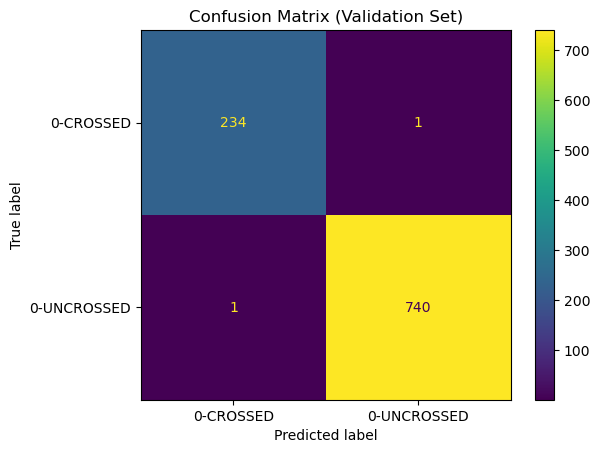

In [44]:
# --- PARAMETERS ---
BATCH_SIZE = 32
IMG_SIZE = 64
VAL_DIR = "validacion"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# --- LOAD VALIDATION DATASET ---
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# --- LOAD MODEL ---
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 1)
model.load_state_dict(torch.load("cell_cross_classifier.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# --- EVALUATE ---
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        outputs = model(imgs)
        preds = (torch.sigmoid(outputs) > 0.5).int().cpu().numpy().flatten()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy().flatten())

acc = np.mean(np.array(y_true) == np.array(y_pred))
print(f"Validation Accuracy: {acc:.3%}")

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=val_dataset.classes)
disp.plot()
plt.title("Confusion Matrix (Validation Set)")
plt.show()

Errores encontrados: 2
class_to_idx: {'0-CROSSED': 0, '0-UNCROSSED': 1}


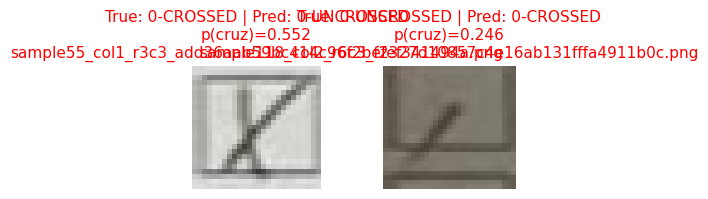

In [ ]:
# Ver las imagenes mal clasificadas

# Inferencia sobre todo validation para obtener etiquetas, predicciones y probabilidades
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        probs  = torch.sigmoid(logits).squeeze(1).cpu().numpy()          # p(clase_positiva = "cruz")
        preds  = (probs > 0.5).astype(np.int32)

        y_prob.extend(probs.tolist())
        y_pred.extend(preds.tolist())
        y_true.extend(labels.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Índices de errores
mis_idx = np.where(y_true != y_pred)[0]
print(f"Errores encontrados: {len(mis_idx)}")

# Mapeo índice↔ruta de archivo (ImageFolder mantiene rutas en .samples en el mismo orden del DataLoader sin shuffle)
file_paths = [val_dataset.samples[i][0] for i in range(len(val_dataset))]

# Nombres de clases (p.ej., ['no_cruz', 'cruz']) y verificación de índice de clase positiva
class_names = val_dataset.classes
print("class_to_idx:", val_dataset.class_to_idx)  # útil para confirmar cuál es la clase positiva

# Función para cargar imagen original sin transformaciones (para mostrarla “como está”)
def load_image_original(path):
    img = Image.open(path).convert("RGB")
    return img

# Plot de todas las imágenes mal clasificadas (o las primeras N si preferís)
N = len(mis_idx)  # puedo limitar a 2 si se que hay solo dos errores
cols = 2
rows = int(np.ceil(N / cols)) if N > 0 else 1
plt.figure(figsize=(2*cols, 2*rows))

for k, i in enumerate(mis_idx[:N]):
    ax = plt.subplot(rows, cols, k+1)
    img = load_image_original(file_paths[i])

    true_lbl_idx = int(y_true[i])
    pred_lbl_idx = int(y_pred[i])
    prob_cross   = float(y_prob[i])  # probabilidad de "cruz" (clase positiva)

    true_name = class_names[true_lbl_idx]
    pred_name = class_names[pred_lbl_idx]

    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        f"True: {true_name} | Pred: {pred_name}\n"
        f"p(cruz)={prob_cross:.3f}\n{os.path.basename(file_paths[i])}",
        fontsize=11, color="red"  # rojo para destacar que es error
    )

plt.tight_layout()
plt.show()


Uso la red para identificar cruces en una imagen random

/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/federico/miniconda3/envs/fedenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Procesando carpeta: sample1


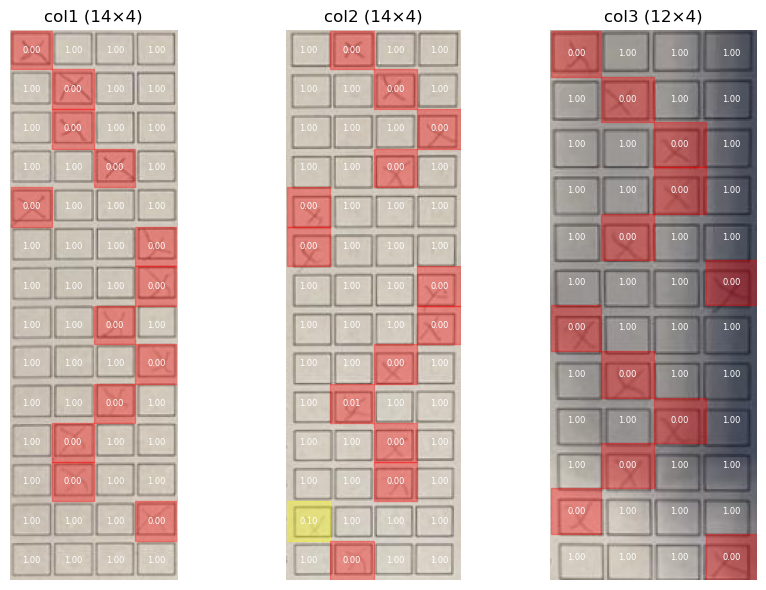

In [2]:
# — configuración —
CROPS_DIR = "crops_prueba"
MODEL_PATH = "cell_cross_classifier.pt"
IMG_SIZE   = 64
DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# filas×columnas por clase
grid_specs = {
    "col1": (14, 4),
    "col2": (14, 4),
    "col3": (12, 4),
}

# cargo modelo
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.last_channel, 1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE).eval()

# pipeline de preprocesado
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

# elijo carpeta al azar
folders = [d for d in os.listdir(CROPS_DIR) 
           if os.path.isdir(os.path.join(CROPS_DIR, d))]
folder = random.choice(folders)
folder_path = os.path.join(CROPS_DIR, folder)
print("Procesando carpeta:", folder)

# qué grids están presentes
grids = [name for name in grid_specs
         if os.path.exists(os.path.join(folder_path, f"{name}.png"))]

# preparo figura
fig, axes = plt.subplots(1, len(grids), figsize=(3*len(grids), 6))
if len(grids) == 1:
    axes = [axes]

for ax, cls_name in zip(axes, grids):
    rows, cols = grid_specs[cls_name]
    img_path = os.path.join(folder_path, f"{cls_name}.png")
    bgr = cv2.imread(img_path)
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = rgb.shape
    cell_h, cell_w = h/rows, w/cols

    ax.imshow(rgb)
    ax.set_title(f"{cls_name} ({rows}×{cols})")
    ax.axis("off")

    # recorro cada casillero
    for i in range(rows):
        for j in range(cols):
            y1, y2 = int(i*cell_h), int((i+1)*cell_h)
            x1, x2 = int(j*cell_w), int((j+1)*cell_w)
            cell = rgb[y1:y2, x1:x2]

            # inferencia
            inp = preprocess(cell).unsqueeze(0).to(DEVICE)
            with torch.no_grad():
                out = model(inp)
                prob = torch.sigmoid(out).item()

            # pinto la probabilidad siempre
            ax.text(
                x1 + (x2-x1)/2,
                y1 + (y2-y1)/2,
                f"{prob:.2f}",
                color='white', fontsize=6,
                ha='center', va='center'
            )

            # decido overlay según prob
            if prob < 0.10:
                color, alpha = 'red', 0.35    # ahora rojo = no-cross
            elif prob <= 0.90:
                color, alpha = 'yellow', 0.35 # sigue amarillo = incierto
            else:
                color = None                 # prob >0.90: nada

            if color:
                rect = plt.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    color=color, alpha=alpha
                )
                ax.add_patch(rect)

plt.tight_layout()
plt.show()